In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing
import glob
import pandas as pd
from scipy.optimize import curve_fit

In [2]:
def compute_FFC(base_run,pcr_run,include_nan=False):
    a = base_run/np.sum(base_run)
    b = pcr_run/np.sum(pcr_run)  
    old_settings = np.seterr(divide='ignore',invalid='ignore')
    ampratio = b/a
    if include_nan == False:
        ffc = ampratio[np.isfinite(ampratio)]
    else:
        ffc = ampratio
    _=np.seterr(**old_settings)  # reset to default
    return ffc

def getGCPerc(seq):
    GCCounts = seq.count("G") + seq.count("C")
    return float(GCCounts)/len(seq)

def readSeqFile(seqFile):
    seq_list = []
    with open(seqFile) as fr:
        for line in fr:
            seq = line.rstrip("\r\n")
            seq_list.append(seq)
    return seq_list

def func(x,a,b):
    return a*x+b

In [3]:
GC_all = []
amp_log2_all = np.array([])
for idx in [23, 24, 25, 26, 28, 29, 30, 31]:
    # calculate GC contents
    seq_list = readSeqFile("./seq/Strands_"+str(idx)+".txt")
    GC_list = [getGCPerc(seq) for seq in seq_list]
    GC_all += GC_list
    
    # calculate relative amplification
    base_run = np.load("./reads/run61/hp"+str(idx)+".npy")
    test_run = np.load("./reads/run63/hp"+str(idx)+".npy")
    a = base_run/np.sum(base_run)
    b = test_run/np.sum(test_run)
    old_settings = np.seterr(divide='ignore',invalid='ignore')
    ampratio = b/a
    _=np.seterr(**old_settings)  # reset to default
    amp_log2 = np.log2(ampratio)
    amp_log2_all = np.concatenate((amp_log2_all, amp_log2), axis=0)
    
    
GC_all_perc = [100*gc for gc in GC_all]   

/Users/YuanJyueChen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log2


In [4]:
from scipy import stats
GC_array = np.array(GC_all_perc)
gc_finite = GC_array[np.isfinite(amp_log2_all)]
amp2_log2_finite = amp_log2_all[np.isfinite(amp_log2_all)]
xdata, ydata = gc_finite, amp2_log2_finite
slope, intercept, r_value, p_value, std_err = stats.linregress(xdata, ydata)

print "slope:", slope
print "p_value:", p_value
print "r-squared:", r_value**2
y_fit = func(xdata, slope, intercept)

slope: -0.001956953440781753
p_value: 0.0
r-squared: 0.0010872213421683483


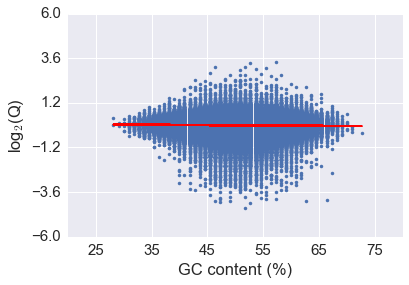

In [7]:
plt.matplotlib.rcParams.update({'font.size':22})
fig, ax1 = plt.subplots(1,1,figsize=(6,4))
ax1.plot(GC_all_perc, amp_log2_all, '.', label="data")
ax1.plot(xdata, y_fit, 'r-', label='fit')
ax1.set_xticks(np.linspace(25, 75, 6))
ax1.set_xlim([20, 80])
ax1.set_yticks(np.linspace(-6,6,6))
ax1.set_xlabel('GC content (%)')
ax1.set_ylabel('log$_2$(Q)')
#plt.savefig('./figs/fig_GC_VS_ampLog_HMO.png', dpi=300, bbox_inches='tight', format='png')

(20, 80)

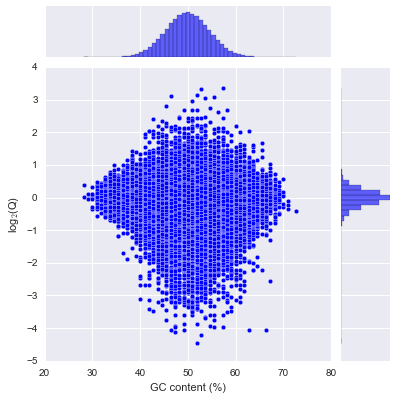

In [5]:
import seaborn as sns
df = pd.DataFrame({"GC content (%)":pd.Series(gc_finite), "log$_2$(Q)":pd.Series(amp2_log2_finite)})
plt.matplotlib.rcParams.update({'font.size':22})
g = sns.JointGrid(x="GC content (%)", y="log$_2$(Q)", data=df)
sns.set(font_scale=1.5)
g = g.plot_joint(plt.scatter, color="b", edgecolor="white")
_ = g.ax_marg_x.hist(df["GC content (%)"], color="b", alpha=.6, bins=50)
_ = g.ax_marg_y.hist(df["log$_2$(Q)"], color="b", alpha=.6,orientation="horizontal", bins=50)
plt.xlim([20,80])
#plt.savefig('./figs/fig_GChist_HMO2.png', dpi=300, bbox_inches='tight', format='png')